In [0]:
## load_Data phase

In [0]:
!pip install kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"ahmedali2019","key":"ee8aa45e05f00dfbff87af6198f44937"}'}

In [0]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
#Data_extracted phase

In [0]:
import zipfile
from tqdm import tqdm

In [0]:
zf = zipfile.ZipFile('chest-xray-pneumonia.zip')
uncompress_size = sum((file.file_size for file in zf.infolist()))
extracted_size = 0
for file in tqdm(zf.infolist()):
    extracted_size += file.file_size
    zf.extract(file)

100%|██████████| 17591/17591 [00:23<00:00, 733.21it/s] 


In [0]:
!ls

chest_xray  chest-xray-pneumonia.zip  kaggle.json  sample_data


In [0]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle 
import scipy
import skimage
from skimage.transform import resize

In [0]:
print(os.listdir("/content/chest_xray/chest_xray"))

['train', 'test', 'val', '.DS_Store']


In [0]:
!pwd

/content


In [0]:
print(os.listdir("/content/chest_xray/chest_xray/train/"))

['NORMAL', 'PNEUMONIA', '.DS_Store']


In [0]:
TRAIN_DIR ="/content/chest_xray/chest_xray/train/" 
TEST_DIR  ="/content/chest_xray/chest_xray/test/"

In [0]:
#preprocessing_data phase

In [0]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return  label

In [0]:
def preprocessing_data(Dir):
    X_data = []
    y_data = []
    
    for nextdir in os.listdir(Dir):
        label = get_label(Dir)
        temp = Dir + nextdir
        if not nextdir.startswith('.'):
          for image_filename in tqdm(os.listdir(temp)):
          
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path)
            if img is not None:
                img = skimage.transform.resize(img, (300, 300, 3))
                img = np.asarray(img)
                X_data.append(img)
                y_data.append(label)
            
    X_data = np.asarray(X)
    y_data = np.asarray(y)
    
    return X_data,y_data
    

        
    

In [0]:
X_train, y_train = preprocessing_data(TRAIN_DIR)

100%|██████████| 3876/3876 [11:15<00:00,  6.76it/s]


In [0]:
X_test , y_test = preprocessing_data(TEST_DIR)

100%|██████████| 390/390 [00:57<00:00,  5.59it/s]


In [0]:
print(X_train.shape,'\n',X_test.shape)

(5216, 150, 150, 3) 
 (624, 150, 150, 3)


In [0]:

print(y_train.shape,'\n',y_test.shape)

(5216, 2) 
 (624, 2)


In [0]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [0]:
print(y_train.shape,'\n',y_test.shape)

(5216, 2) 
 (624, 2)


In [0]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:

filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:

from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils


In [0]:
from keras import backend as K

K.set_image_data_format('channels_first')
K.image_data_format()

'channels_first'

In [0]:

X_train=X_train.reshape(5216,3,150,150)
X_test=X_test.reshape(624,3,150,150)

In [0]:
#model_architecture  contain 15 layer for cnn and 2 layer nn

In [0]:
def swish_activation(x):
    return (K.sigmoid(x) * x)
model = Sequential()



model.add(Conv2D(16, (3,3), activation='relu', padding="same",input_shape=(3,150,150)))
model.add(Conv2D(16, (3,3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), activation='relu', padding="same"))
model.add(Conv2D(32, (3,3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu', padding="same"))
model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3,3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3,3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3,3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3,3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))




model.add(Flatten())

model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='softmax'))

model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.00005),
                  metrics=['accuracy'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 16, 150, 150)      448       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 150, 150)      2320      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 75, 75)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 75, 75)        4640      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 75, 75)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 37, 37)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 64, 37, 37)       

In [0]:
#train phase

In [0]:
batch_size = 256
epochs = 8

In [0]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,epochs=epochs)

Train on 5216 samples, validate on 624 samples
Epoch 1/8
5216/5216 [==============================] - 7s 1ms/step - loss: 0.5714 - acc: 0.7402 - val_loss: 0.5912 - val_acc: 0.6250

Epoch 00001: val_acc improved from -inf to 0.62500, saving model to weights.hdf5
Epoch 2/8
5216/5216 [==============================] - 6s 1ms/step - loss: 0.3952 - acc: 0.8135 - val_loss: 0.4514 - val_acc: 0.7901

Epoch 00002: val_acc improved from 0.62500 to 0.79006, saving model to weights.hdf5
Epoch 3/8
5216/5216 [==============================] - 6s 1ms/step - loss: 0.3311 - acc: 0.8530 - val_loss: 0.3804 - val_acc: 0.8317

Epoch 00003: val_acc improved from 0.79006 to 0.83173, saving model to weights.hdf5
Epoch 4/8
5216/5216 [==============================] - 6s 1ms/step - loss: 0.2975 - acc: 0.8725 - val_loss: 0.4361 - val_acc: 0.8141

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00004: val_acc did not improve from 0.83173
Epoch 5/8
5216/5216 [================

In [0]:
#evaluate phase

In [0]:

loss,acc=model.evaluate(X_test,y_test)

624/624 [==============================] - 0s 533us/step


In [0]:
print(round(acc*100),"  ",loss)

83.0    0.4018236815165251


In [0]:
#resoult ploting phase

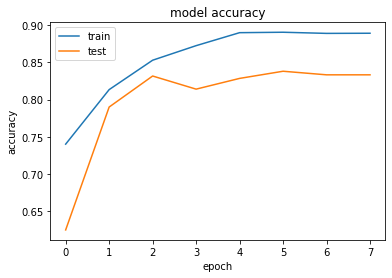

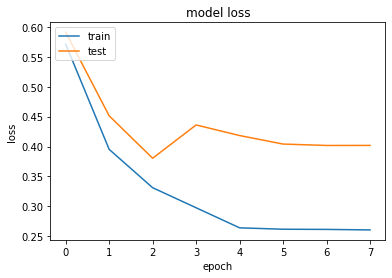

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#predactio phase

In [0]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

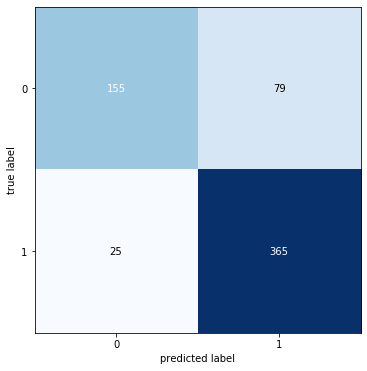

In [0]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(6, 6))
plt.show()

In [0]:
365 / (365 + 79)

0.8220720720720721

In [0]:
382 / (382 + 25)

0.9385749385749386

In [0]:
model.save_weights('first_try.h5')

In [0]:
img_ore = cv2.imread('/content/chest_xray/test/NORMAL/IM-0005-0001.jpeg',cv2.IMREAD_GRAYSCALE)
                
               

In [0]:
img_ore = skimage.transform.resize(img_ore, (150, 150, 3))
img_ore = np.asarray(img_ore)

In [0]:
img_ore.shape

(150, 150, 3)

In [0]:
#from keras.utils.np_utils import to_categorical
#img_ore = to_categorical(img_ore, 2)


In [0]:
zzz=[]

In [0]:
zzz.append(img_ore)

In [0]:
zzz=np.asarray(zzz)

In [0]:
zzz.shape

(1, 150, 150, 3)

In [0]:
zzz=zzz.reshape(1,3,150,150)

In [0]:
print(model.predict(zzz))

[[0.8227018  0.17845787]]


In [0]:
# in output we show first ration is beger second ration 
# we know the first ration mean the normal  then the presect is true 